# Stage 5 (3.5 recs_analysis)

# Импортируем библиотеки

In [1]:
import warnings

import dill

import numpy as np
import polars as pl
import pandas as pd

from tqdm.auto import tqdm

from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt

import seaborn as sns

# USE THIS STYLE
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
# 
# OR THIS STYLE
import aquarel

from metrics import RecommenderMetrics


theme = aquarel.load_theme("arctic_light")
theme.set_font(family="serif")
theme.apply()


warnings.filterwarnings("ignore")


RANDOM_STATE = 42

# Импортируем пути

In [2]:
data_path = "../data/closed/"

In [3]:
models_path = "../data/models/"

In [4]:
candidates_data_path = models_path + "candidates_data/"

# Что надо посмотреть? 

- Посчитаем метрики
- Что нарекомендовали модели (рекомендации для холодных пользователей учитывать при анализе не будем): 
    - топ популярных
    - бренд товара был сильной фитчей для ранкера: рассмотрим распределение для брендов и тренды внутри них
    - будет интересно посмотреть на топы внутри категориальных фичей
    <!-- - если останется время, то рассмотреть интересные статистики популярности в зависимости от различных фитчей -->

# Load predictions

In [ ]:
df_candidates = pl.scan_parquet(
    candidates_data_path + f"CB_ranker_predictions_bNr_0.parquet"
)

for i in tqdm(range(1, 5)):
    df_candidates = pl.concat(
        [
            df_candidates,
            pl.scan_parquet(
                candidates_data_path + f"CB_ranker_predictions_bNr_{i}.parquet",
            ),
        ],
        how="vertical",
    )

# Итоговые метрики на тесте

In [8]:
predictions = (
    df_candidates.filter(pl.col("listwise_hybrid_rank") <= 15)
    .select(["user_id", "item_id"])
    .group_by("user_id")
    .agg(pl.col("item_id").alias("listwise_hybrid_rank_recs"))
)

In [ ]:
for k in [3, 5, 10, 15]:
    print(
        f"""k = {k}: {RecommenderMetrics.evaluate_recommender(
            pl.scan_parquet(data_path + "test_df.parquet")
            .filter(pl.col("user_id").is_in(predictions.select("user_id").unique().collect()))
            .join(
                other=predictions,
                how="left",
                on="user_id",
            )
            .collect(),
            model_preds_col="listwise_hybrid_rank_recs",
            k=k,
        )}\n"""
    )

k = 3: {'ndcg@k': 0.23283668145585287, 'recall@k': 0.1507586238930032, 'map@k': 0.16838806967687284}

k = 5: {'ndcg@k': 0.2672899635214155, 'recall@k': 0.1784753701591795, 'map@k': 0.16011627018530403}

k = 10: {'ndcg@k': 0.3140544182833436, 'recall@k': 0.21806060763468477, 'map@k': 0.1566453522770767}

k = 15: {'ndcg@k': 0.3387634076939192, 'recall@k': 0.24039676206392474, 'map@k': 0.1565731543568892}



## Итого, имеем следующие метрики:

### ДО

k = 3: {'ndcg@k': 0.2066009927816457, 'recall@k': 0.12447302675108117, 'map@k': 0.14127237787969413}

k = 5: {'ndcg@k': 0.24092300833035926, 'recall@k': 0.14942065114748218, 'map@k': 0.13471953670207448}

k = 10: {'ndcg@k': 0.2951177111158031, 'recall@k': 0.19172486787876636, 'map@k': 0.13414947362623275}

k = 15: {'ndcg@k': 0.3262363181849842, 'recall@k': 0.2175279962499981, 'map@k': 0.13528035914656342}

### ПОСЛЕ

k = 3: {'ndcg@k': 0.23283668145585287, 'recall@k': 0.1507586238930032, 'map@k': 0.16838806967687284}

k = 5: {'ndcg@k': 0.2672899635214155, 'recall@k': 0.1784753701591795, 'map@k': 0.16011627018530403}

k = 10: {'ndcg@k': 0.3140544182833436, 'recall@k': 0.21806060763468477, 'map@k': 0.1566453522770767}

k = 15: {'ndcg@k': 0.3387634076939192, 'recall@k': 0.24039676206392474, 'map@k': 0.1565731543568892}

Модель была дотюнена, в следствии чего метрики на тесте выросли, хотя при валидации была просадка по ним, возможно до этого словили переобучение

# Раскодируем данные

In [6]:
# Из cols следующие фитчи категориальные
CATEGORIAL_FEATURES = [
    "brand",
    "color",
    "closure",
    "country",
    "cut",
    "height",
    "length",
    "material",
    "model",
    "neckline",
    "pattern",
    "pocket",
    "purpose",
    "sleeve",
]

In [7]:
# Load encoder
with open(models_path + "df_items_encoder.dill", "rb") as f:
    items_cat_enc = dill.load(f)

In [8]:
df_candidates[CATEGORIAL_FEATURES] = items_cat_enc.inverse_transform(df_candidates[CATEGORIAL_FEATURES])

# Загрузим таблицу айтемов

In [9]:
with open(data_path + "df_items.dill", "rb") as f:
    df_items = dill.load(f)
    df_items = df_items.drop(columns=[f"txt_emb_pca_{i}" for i in range(10)])
    df_items = df_items.drop(columns=[f"img_pca_{i}" for i in range(10)])

# Coставим рейтинг из рекомендованых товаров

In [10]:
df_items_pred = (
    df_candidates["item_id"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"count": "item_count"})
)
df_items_pred["item_rating"] = df_items_pred["item_count"] / df_items_pred["item_count"].sum()

# Рейтинг на train данных

In [11]:
with open(data_path + "item_rating.dill", "rb") as f:
    df_items_train = dill.load(f)

In [12]:
df_items_train = pd.merge(
    left=df_items_train,
    right=df_items,
    on="item_id",
    how="left",
)

# Coставим рейтинг из test товаров

In [13]:
with open(data_path + "test_df.dill", "rb") as f:
    df_items_test = (
        pd.DataFrame(dill.load(f)["item_id"].explode())
        .value_counts()
        .to_frame()
        .reset_index()
        .rename(columns={"count": "item_count"})
    )

In [14]:
df_items_test = pd.merge(
    left=df_items_test,
    right=df_items,
    on="item_id",
    how="left",
)

# Brand

In [15]:
df_brand_rating_pred = (
    df_candidates["brand"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"count": "item_count"})
)
df_brand_rating_pred

,brand,item_count
0,obba,214088
1,тысяча столиц,167476
2,none,151242
3,тысяча столиц qianzhidu,135985
4,with street,115393
...,...,...
22925,italy,1
22926,beribegi,1
22927,gallant touch,1
22928,kivi style,1


In [16]:
df_brand_rating_train = (
    df_items_train.groupby(by="brand").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_brand_rating_train

,brand,item_count
17467,obba,680581
17216,none,391071
27320,тысяча столиц,337522
18376,pimari,293421
20430,serenada,266326
...,...,...
19805,sabb,1
10913,katerina pikmeeva,1
3625,betti moon,1
13398,luna_brand,1


In [17]:
df_brand_rating_test = (
    df_items_test.groupby(by="brand").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_brand_rating_test

,brand,item_count
13939,obba,125461
13752,none,83928
1770,ardanix,72659
14664,pimari,68156
21710,тысяча столиц,67727
...,...,...
10550,loving dress,1
10545,lovexler,1
19065,vittoria,1
10543,loveto,1


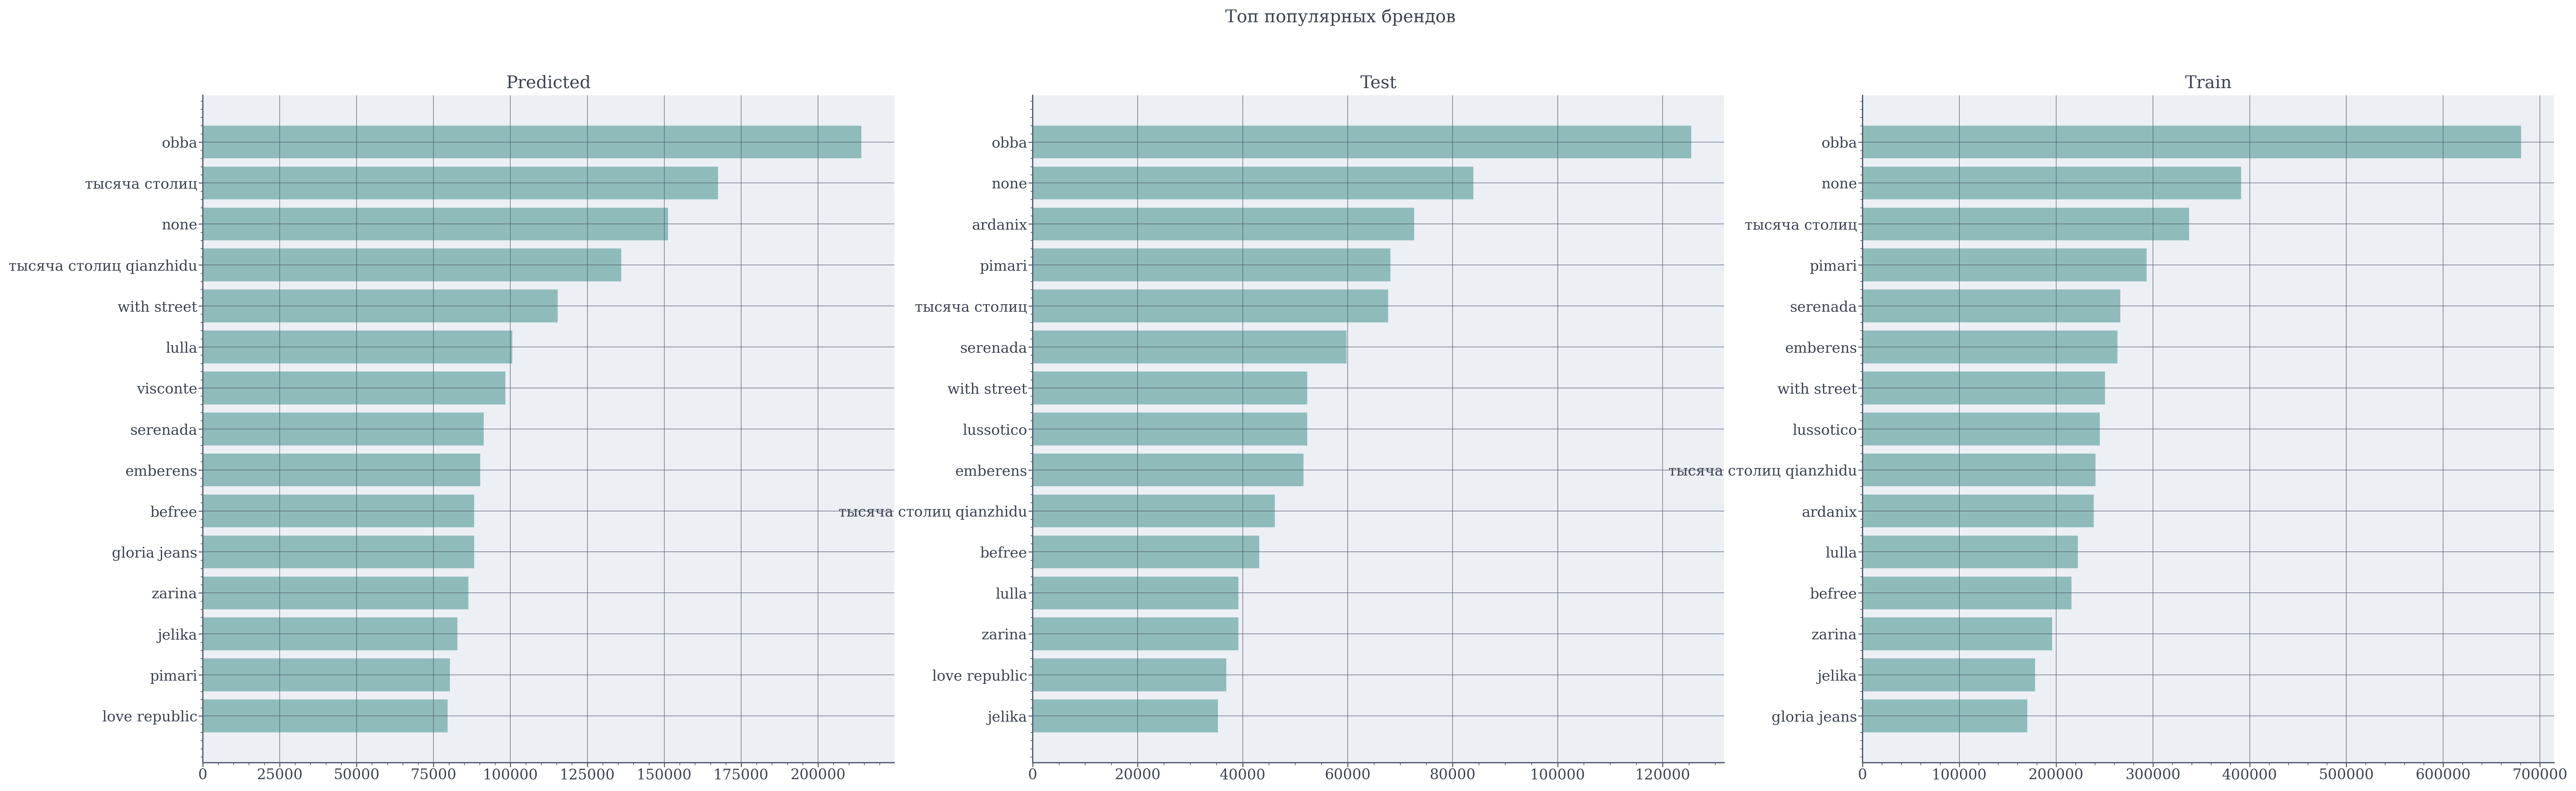

In [18]:
plot_info = {
    "title": "Топ популярных брендов",
    "xlabel": "",
    "ylabel": "",
}


fig, ax = plt.subplots(1, 3, figsize=(35, 10), dpi=300)

fig.suptitle(plot_info["title"])


# Create the bar plot
ax[0].barh(
    df_brand_rating_pred["brand"].iloc[[i for i in range(14, -1, -1)]],
    df_brand_rating_pred["item_count"].iloc[[i for i in range(14, -1, -1)]],
)
ax[0].set_title("Predicted")


# Create the bar plot
ax[1].barh(
    df_brand_rating_test["brand"].iloc[[i for i in range(14, -1, -1)]],
    df_brand_rating_test["item_count"].iloc[[i for i in range(14, -1, -1)]],
)
ax[1].set_title("Test")

# Create the bar plot
ax[2].barh(
    df_brand_rating_train["brand"].iloc[[i for i in range(14, -1, -1)]],
    df_brand_rating_train["item_count"].iloc[[i for i in range(14, -1, -1)]],
)
ax[2].set_title("Train")



plt.show()

# Lenght

In [19]:
df_items_lenght_rating = (
    df_candidates["length"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"count": "item_count"})
    .sort_values(by="length")
)
df_items_lenght_rating

,length,item_count
3,unknown,2148398
2,макси,3635413
0,миди,8451710
1,мини,3709557


In [20]:
df_items_lenght_rating_train = (
    df_items_train.groupby(by="length").agg({"item_count": "sum"}).reset_index().sort_values(by="length")
)
df_items_lenght_rating_train

,length,item_count
0,unknown,5584749
1,макси,9665901
2,миди,22188514
3,мини,9405282


In [21]:
df_length_rating_test = (
    df_items_test.groupby(by="length").agg({"item_count": "sum"}).reset_index().sort_values(by="length")
)
df_length_rating_test

,length,item_count
0,unknown,1157213
1,макси,2047246
2,миди,4725428
3,мини,1876714


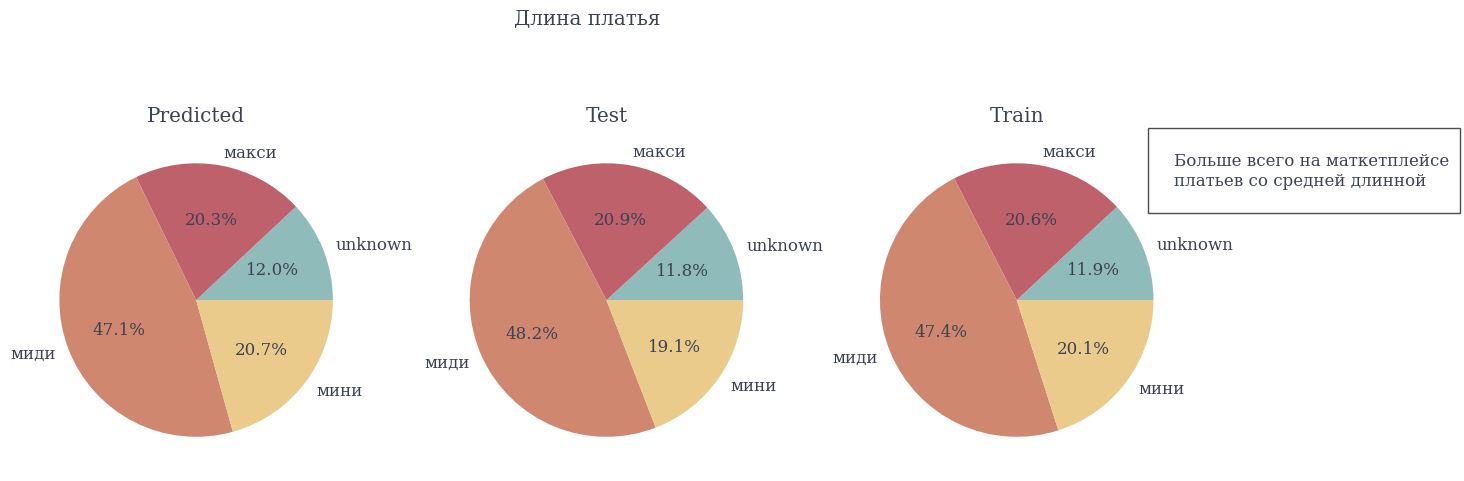

In [22]:
text_for_pieplot = f"""
    Больше всего на маткетплейсе 
    платьев со средней длинной
"""

plot_info = {
    "title": "Длина платья",
    "xlabel": "",
    "ylabel": "",
    "text": text_for_pieplot,
}


fig, ax = plt.subplots(1, 3, figsize=(15, 6))  # , dpi=500)

fig.suptitle(plot_info["title"])

ax[0].pie(
    x=df_items_lenght_rating["item_count"],
    labels=df_items_lenght_rating["length"],
    autopct="%1.1f%%",
)

ax[0].set(
    title="Predicted",
)


ax[1].pie(
    x=df_length_rating_test["item_count"],
    labels=df_length_rating_test["length"],
    autopct="%1.1f%%",
)

ax[1].set(
    title="Test",
)


ax[2].pie(
    x=df_items_lenght_rating_train["item_count"],
    labels=df_items_lenght_rating_train["length"],
    autopct="%1.1f%%",
)

ax[2].set(
    title="Train",
)

ax[2].annotate(
    plot_info["text"],
    xy=(1, 0.7),
    bbox=dict(boxstyle="square", fc="w", alpha=0.7),
    fontsize=12,
    alpha=1,
)



plt.show()

# Model

In [23]:
df_model_rating_pred = (
    df_candidates["model"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"count": "item_count"})
)
df_model_rating_pred

,model,item_count
0,unknown,5452058
1,футляр,2028147
2,прямое,1982077
3,трапеция,1248481
4,вязаное,1086130
5,лапша,950768
6,открытое,917033
7,рубашка,876025
8,запах,677597
9,водолазка,442381


In [24]:
df_model_rating_train = (
    df_items_train.groupby(by="model").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_model_rating_train

,model,item_count
0,unknown,14647330
25,футляр,5198368
17,прямое,4957584
22,трапеция,3549092
4,вязаное,2534109
12,открытое,2458967
18,рубашка,2369528
8,лапша,2110149
5,запах,1856802
3,водолазка,1107356


In [25]:
df_model_rating_test = (
    df_items_test.groupby(by="model").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_model_rating_test

,model,item_count
0,unknown,3090612
25,футляр,1110540
17,прямое,1029786
22,трапеция,762454
12,открытое,523242
18,рубашка,501809
4,вязаное,491095
8,лапша,437600
5,запах,402150
3,водолазка,213593


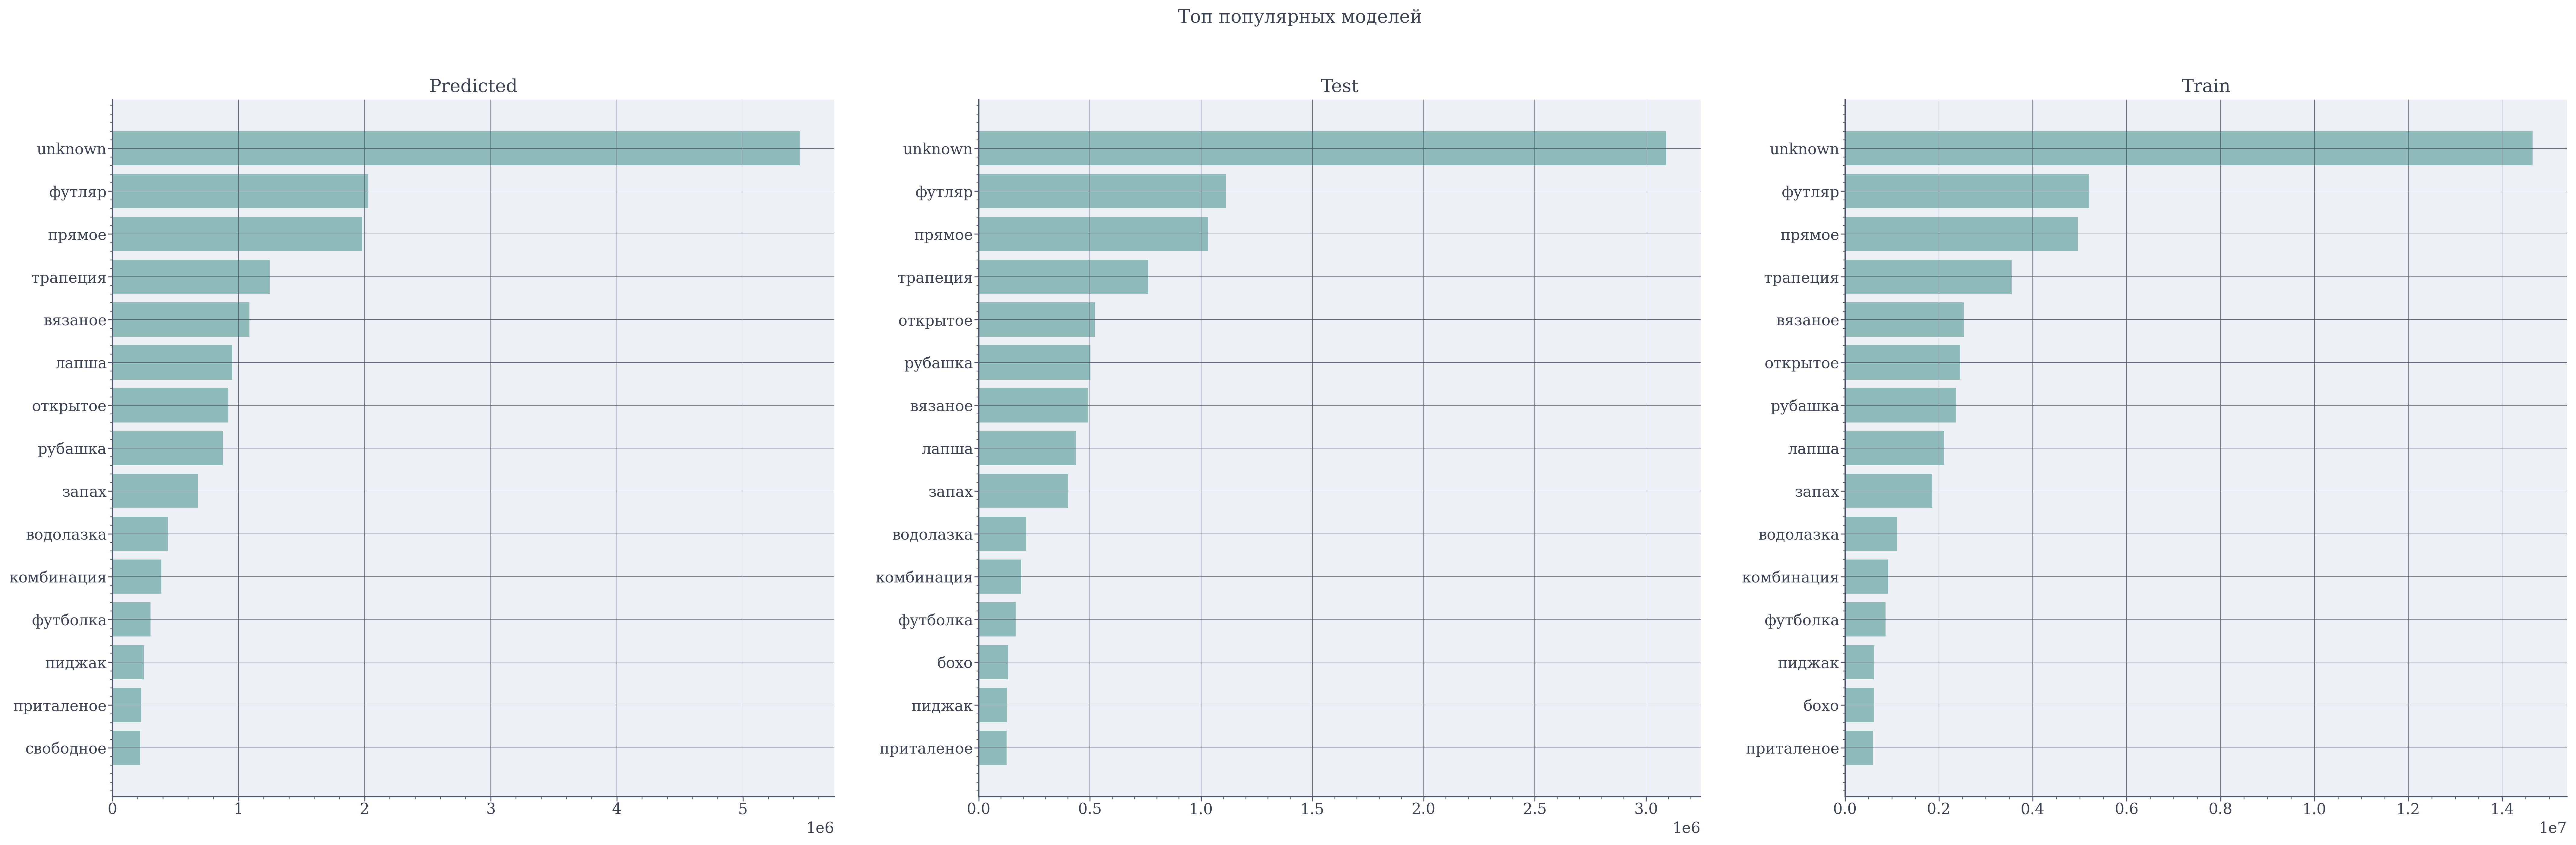

In [26]:
plot_info = {
    "title": "Топ популярных моделей",
    "xlabel": "",
    "ylabel": "",
    "text_1": text_for_pieplot,
    "text_2": text_for_pieplot,
}


fig, ax = plt.subplots(1, 3, figsize=(35, 10), dpi=300)

fig.suptitle(plot_info["title"])


# Create the bar plot
ax[0].barh(
    df_model_rating_pred["model"].iloc[[i for i in range(14, -1, -1)]],
    df_model_rating_pred["item_count"].iloc[[i for i in range(14, -1, -1)]],
)
ax[0].set_title("Predicted")


# Create the bar plot
ax[1].barh(
    df_model_rating_test["model"].iloc[[i for i in range(14, -1, -1)]],
    df_model_rating_test["item_count"].iloc[[i for i in range(14, -1, -1)]],
)
ax[1].set_title("Test")

# Create the bar plot
ax[2].barh(
    df_model_rating_train["model"].iloc[[i for i in range(14, -1, -1)]],
    df_model_rating_train["item_count"].iloc[[i for i in range(14, -1, -1)]],
)
ax[2].set_title("Train")



plt.show()

# Pattern

In [27]:
df_pattern_rating_pred = (
    df_candidates["pattern"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"count": "item_count"})
)
df_pattern_rating_pred

,pattern,item_count
0,без рисунка,8960203
1,unknown,4566294
2,цветы,1443267
3,фигуры,1142264
4,горох,650029
5,абстракция,411038
6,леопардовый,328152
7,полоска,275441
8,клетка,168390


In [28]:
df_pattern_rating_train = (
    df_items_train.groupby(by="pattern").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_pattern_rating_train

,pattern,item_count
2,без рисунка,22525708
0,unknown,12064423
8,цветы,4166784
7,фигуры,3011356
3,горох,1781429
1,абстракция,1201327
5,леопардовый,868331
6,полоска,728534
4,клетка,496554


In [29]:
df_pattern_rating_test = (
    df_items_test.groupby(by="pattern").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_pattern_rating_test

,pattern,item_count
2,без рисунка,4736310
0,unknown,2492980
8,цветы,885559
7,фигуры,615020
3,горох,383380
1,абстракция,254760
5,леопардовый,186717
6,полоска,144694
4,клетка,107181


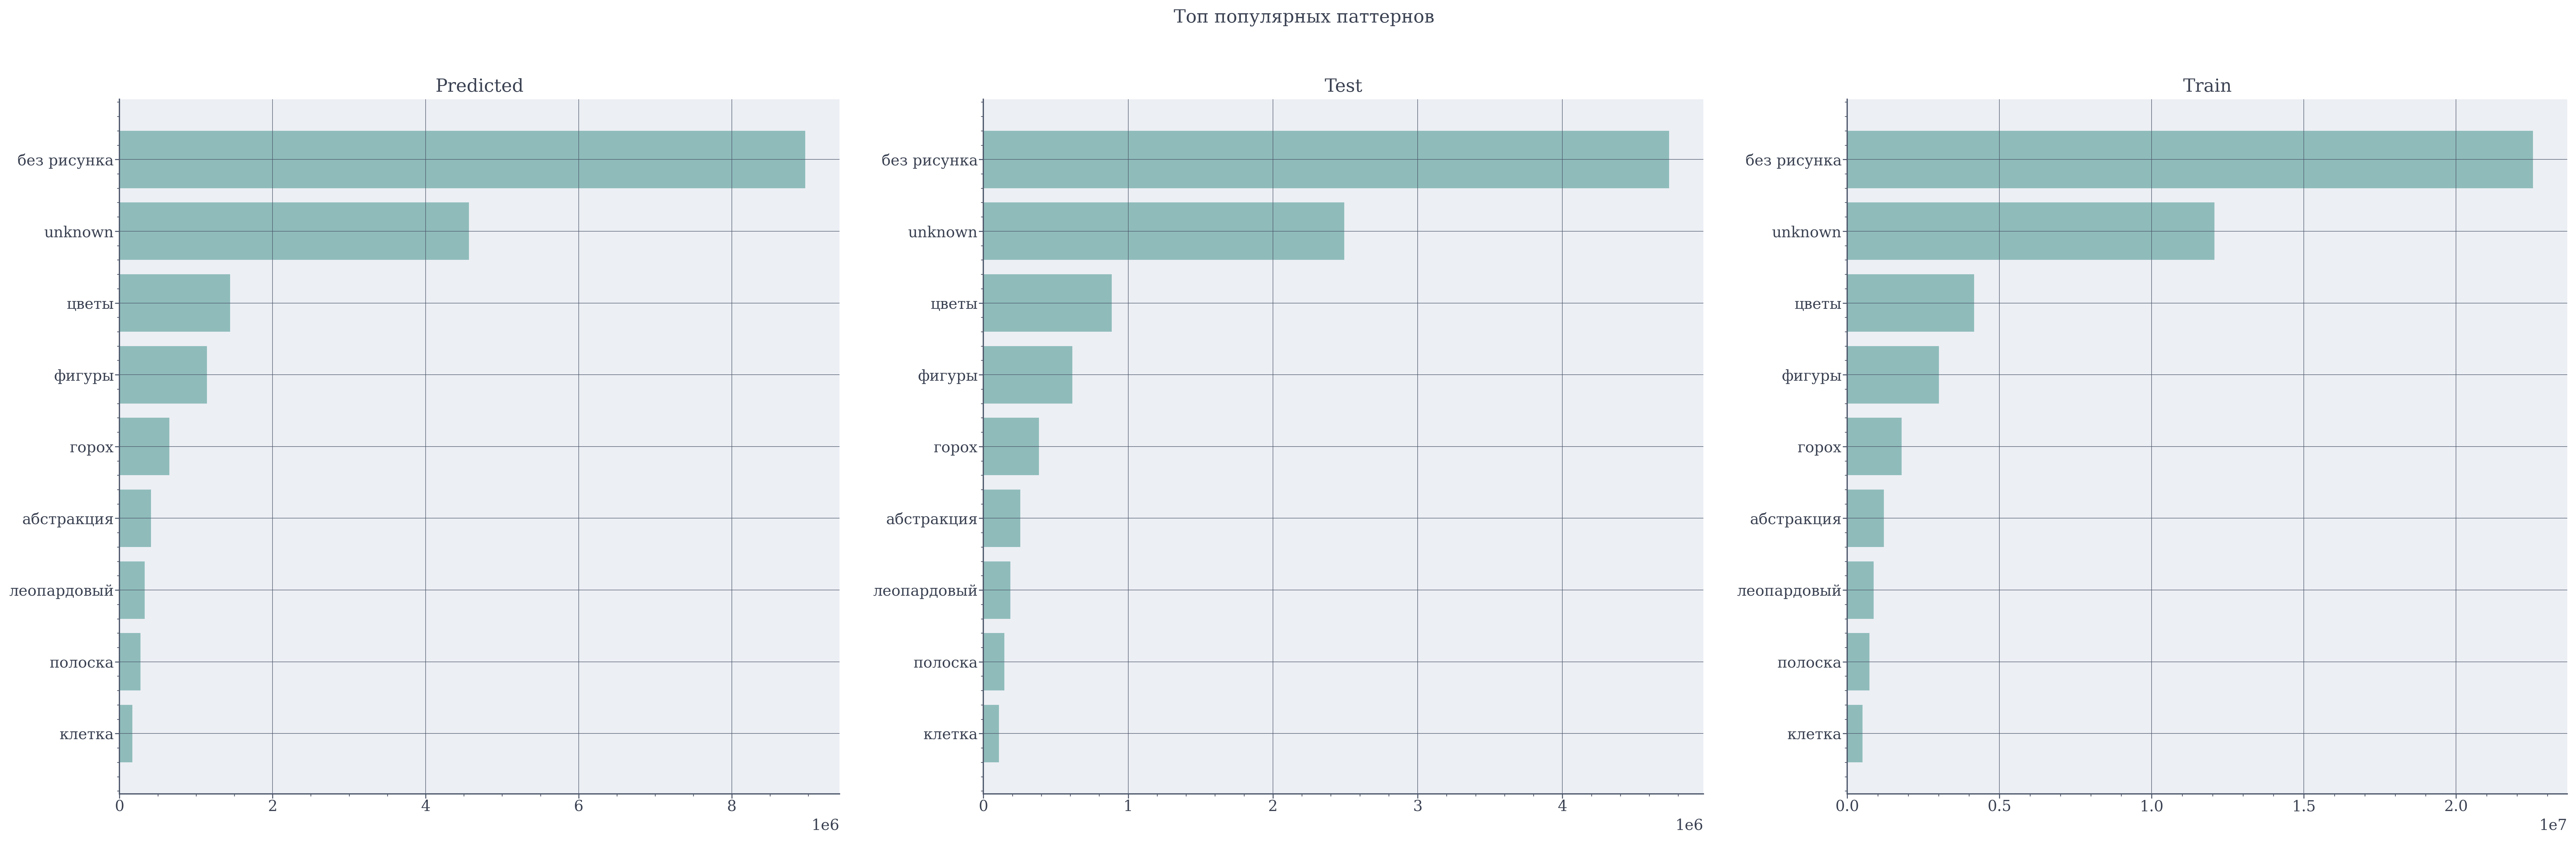

In [30]:
plot_info = {
    "title": "Топ популярных паттернов",
    "xlabel": "",
    "ylabel": "",
    "text_1": text_for_pieplot,
    "text_2": text_for_pieplot,
}


fig, ax = plt.subplots(1, 3, figsize=(35, 10), dpi=300)

fig.suptitle(plot_info["title"])


# Create the bar plot
ax[0].barh(
    df_pattern_rating_pred["pattern"].iloc[[i for i in range(8, -1, -1)]],
    df_pattern_rating_pred["item_count"].iloc[[i for i in range(8, -1, -1)]],
)
ax[0].set_title("Predicted")


# Create the bar plot
ax[1].barh(
    df_pattern_rating_test["pattern"].iloc[[i for i in range(8, -1, -1)]],
    df_pattern_rating_test["item_count"].iloc[[i for i in range(8, -1, -1)]],
)
ax[1].set_title("Test")

# Create the bar plot
ax[2].barh(
    df_pattern_rating_train["pattern"].iloc[[i for i in range(8, -1, -1)]],
    df_pattern_rating_train["item_count"].iloc[[i for i in range(8, -1, -1)]],
)
ax[2].set_title("Train")



plt.show()

# Sleeve

In [31]:
df_sleeve_rating_pred = (
    df_candidates["sleeve"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"count": "item_count"})
)
df_sleeve_rating_pred

,sleeve,item_count
0,длинные,9758200
1,короткие,2521075
2,3/4,2176427
3,без рукавов,1736237
4,unknown,1547665
5,7/8,205474


In [32]:
df_sleeve_rating_train = (
    df_items_train.groupby(by="sleeve").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_sleeve_rating_train

,sleeve,item_count
4,длинные,24389672
5,короткие,7013461
0,3/4,6297808
3,без рукавов,4609316
2,unknown,3952097
1,7/8,582092


In [33]:
df_sleeve_rating_test = (
    df_items_test.groupby(by="sleeve").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_sleeve_rating_test

,sleeve,item_count
4,длинные,5003937
5,короткие,1471057
0,3/4,1381784
3,без рукавов,1002313
2,unknown,819632
1,7/8,127878


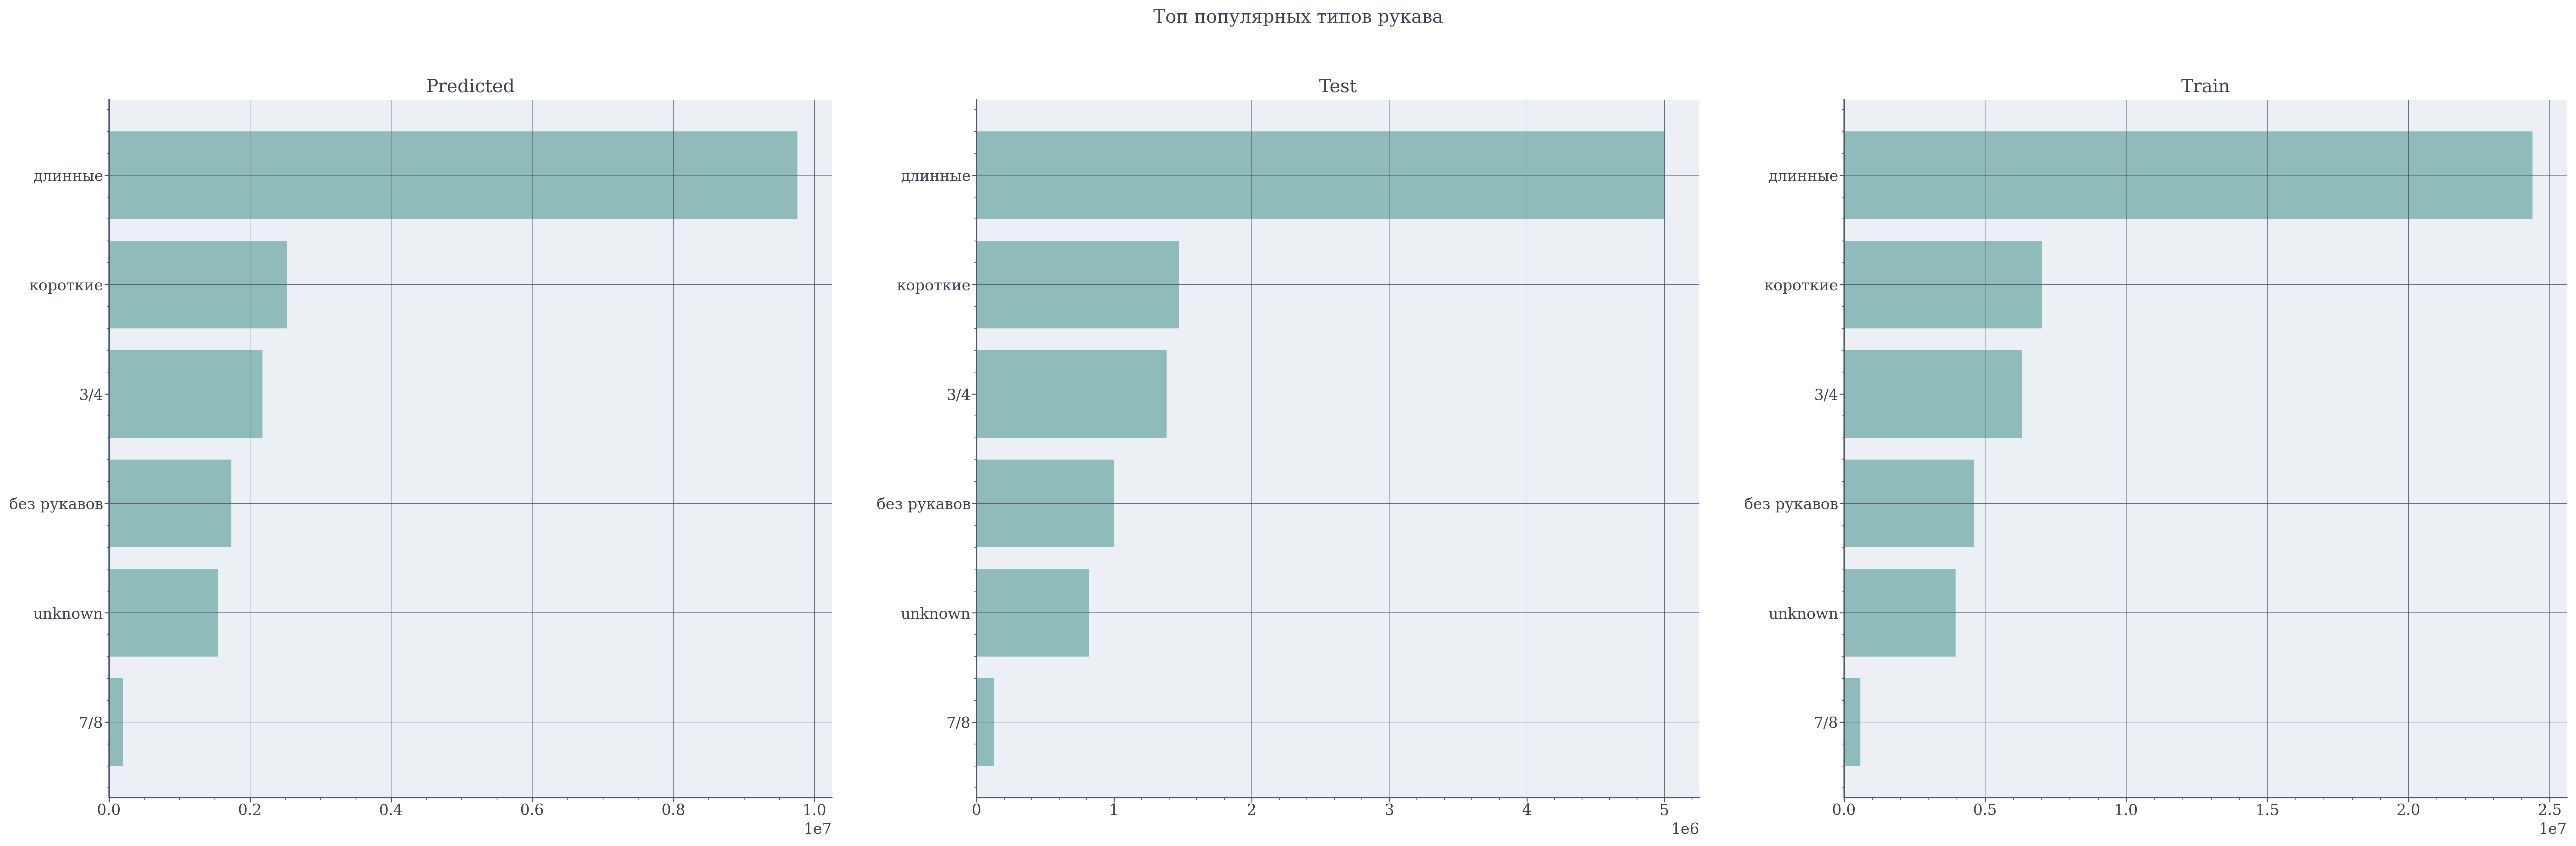

In [34]:
plot_info = {
    "title": "Топ популярных типов рукава",
    "xlabel": "",
    "ylabel": "",
    "text_1": text_for_pieplot,
    "text_2": text_for_pieplot,
}


fig, ax = plt.subplots(1, 3, figsize=(35, 10), dpi=300)

fig.suptitle(plot_info["title"])


# Create the bar plot
ax[0].barh(
    df_sleeve_rating_pred["sleeve"].iloc[[i for i in range(5, -1, -1)]],
    df_sleeve_rating_pred["item_count"].iloc[[i for i in range(5, -1, -1)]],
)
ax[0].set_title("Predicted")


# Create the bar plot
ax[1].barh(
    df_sleeve_rating_test["sleeve"].iloc[[i for i in range(5, -1, -1)]],
    df_sleeve_rating_test["item_count"].iloc[[i for i in range(5, -1, -1)]],
)
ax[1].set_title("Test")

# Create the bar plot
ax[2].barh(
    df_sleeve_rating_train["sleeve"].iloc[[i for i in range(5, -1, -1)]],
    df_sleeve_rating_train["item_count"].iloc[[i for i in range(5, -1, -1)]],
)
ax[2].set_title("Train")



plt.show()

# Neckline

In [35]:
df_neckline_rating_pred = (
    df_candidates["neckline"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"count": "item_count"})
)
df_neckline_rating_pred

,neckline,item_count
0,круглый,6354109
1,v-образный,3555648
2,стойка,1864174
3,u-образный,1806079
4,unknown,1058234
5,отложной,728501
6,лодочка,725987
7,квадратный,457795
8,гольф,374692
9,бретели,282903


In [36]:
df_neckline_rating_train = (
    df_items_train.groupby(by="neckline").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_neckline_rating_train

,neckline,item_count
11,круглый,16888556
2,v-образный,9419618
18,стойка,4701984
0,u-образный,4636153
1,unknown,2688228
12,лодочка,1963089
15,отложной,1929497
9,квадратный,1160327
6,гольф,789503
5,бретели,751790


In [37]:
df_neckline_rating_test = (
    df_items_test.groupby(by="neckline").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_neckline_rating_test

,neckline,item_count
11,круглый,3572064
2,v-образный,1994554
0,u-образный,951995
18,стойка,940621
1,unknown,561921
12,лодочка,418464
15,отложной,400143
9,квадратный,243847
6,гольф,161697
5,бретели,158729


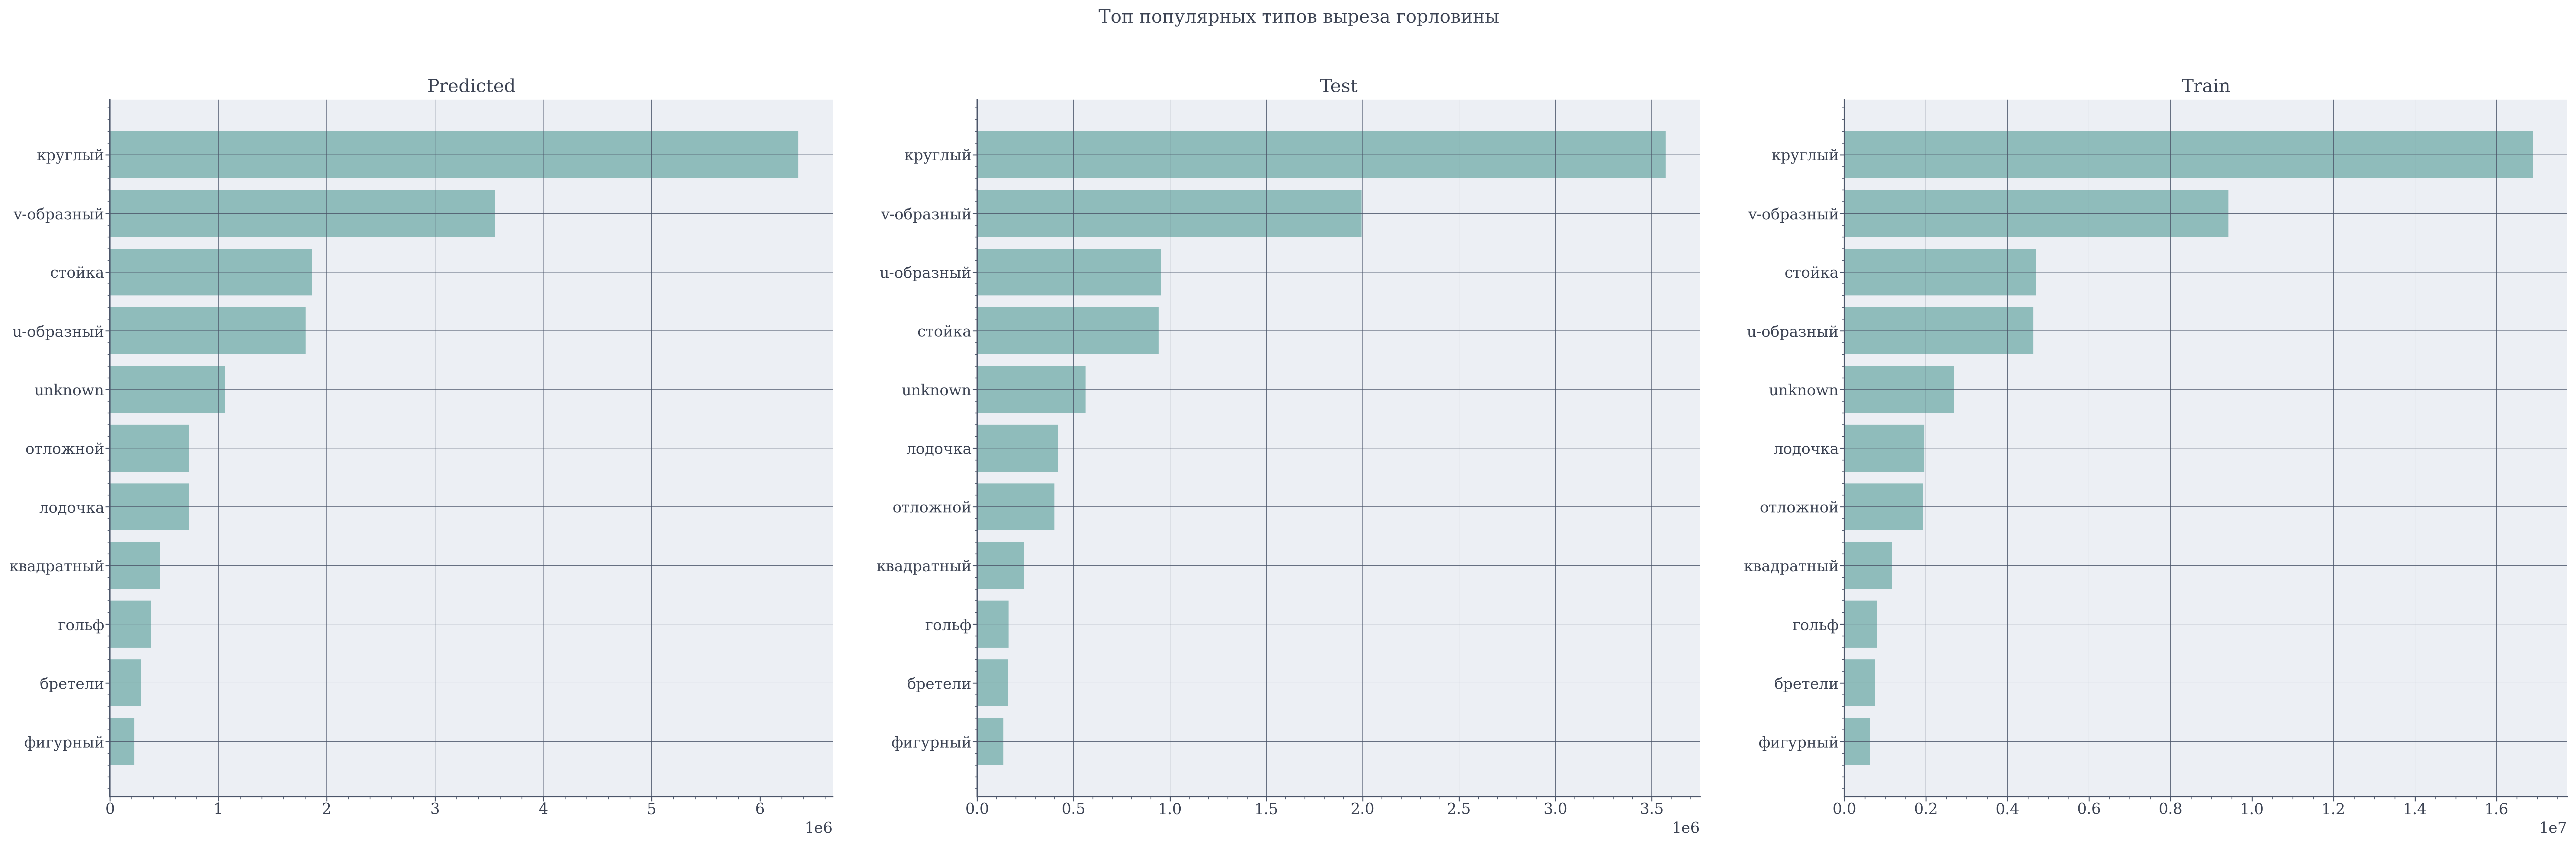

In [38]:
plot_info = {
    "title": "Топ популярных типов выреза горловины",
    "xlabel": "",
    "ylabel": "",
    "text_1": text_for_pieplot,
    "text_2": text_for_pieplot,
}


fig, ax = plt.subplots(1, 3, figsize=(35, 10), dpi=300)

fig.suptitle(plot_info["title"])

N = 10

# Create the bar plot
ax[0].barh(
    df_neckline_rating_pred["neckline"].iloc[[i for i in range(N, -1, -1)]],
    df_neckline_rating_pred["item_count"].iloc[[i for i in range(N, -1, -1)]],
)
ax[0].set_title("Predicted")


# Create the bar plot
ax[1].barh(
    df_neckline_rating_test["neckline"].iloc[[i for i in range(N, -1, -1)]],
    df_neckline_rating_test["item_count"].iloc[[i for i in range(N, -1, -1)]],
)
ax[1].set_title("Test")

# Create the bar plot
ax[2].barh(
    df_neckline_rating_train["neckline"].iloc[[i for i in range(N, -1, -1)]],
    df_neckline_rating_train["item_count"].iloc[[i for i in range(N, -1, -1)]],
)
ax[2].set_title("Train")



plt.show()

# Cut

In [39]:
df_cut_rating_pred = (
    df_candidates["cut"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"count": "item_count"})
)
df_cut_rating_pred

,cut,item_count
0,приталенный,4215367
1,облегающий,3128671
2,свободный,2899487
3,полуприлегающий,1781081
4,прямой,1405666
5,unknown,1321409
6,а-силуэт,1127224
7,оверсайз,1037446
8,трапеция,393287
9,длинный,285674


In [40]:
df_cut_rating_train = (
    df_items_train.groupby(by="cut").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_cut_rating_train

,cut,item_count
7,приталенный,10712376
10,свободный,8007014
4,облегающий,7386828
6,полуприлегающий,4825876
8,прямой,3777755
0,unknown,3419065
1,а-силуэт,3108462
5,оверсайз,2833113
11,трапеция,1057383
3,длинный,739349


In [41]:
df_cut_rating_test = (
    df_items_test.groupby(by="cut").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_cut_rating_test

,cut,item_count
7,приталенный,2301286
10,свободный,1649079
4,облегающий,1528591
6,полуприлегающий,1035049
8,прямой,772153
0,unknown,706055
1,а-силуэт,656483
5,оверсайз,565737
11,трапеция,226844
3,длинный,151959


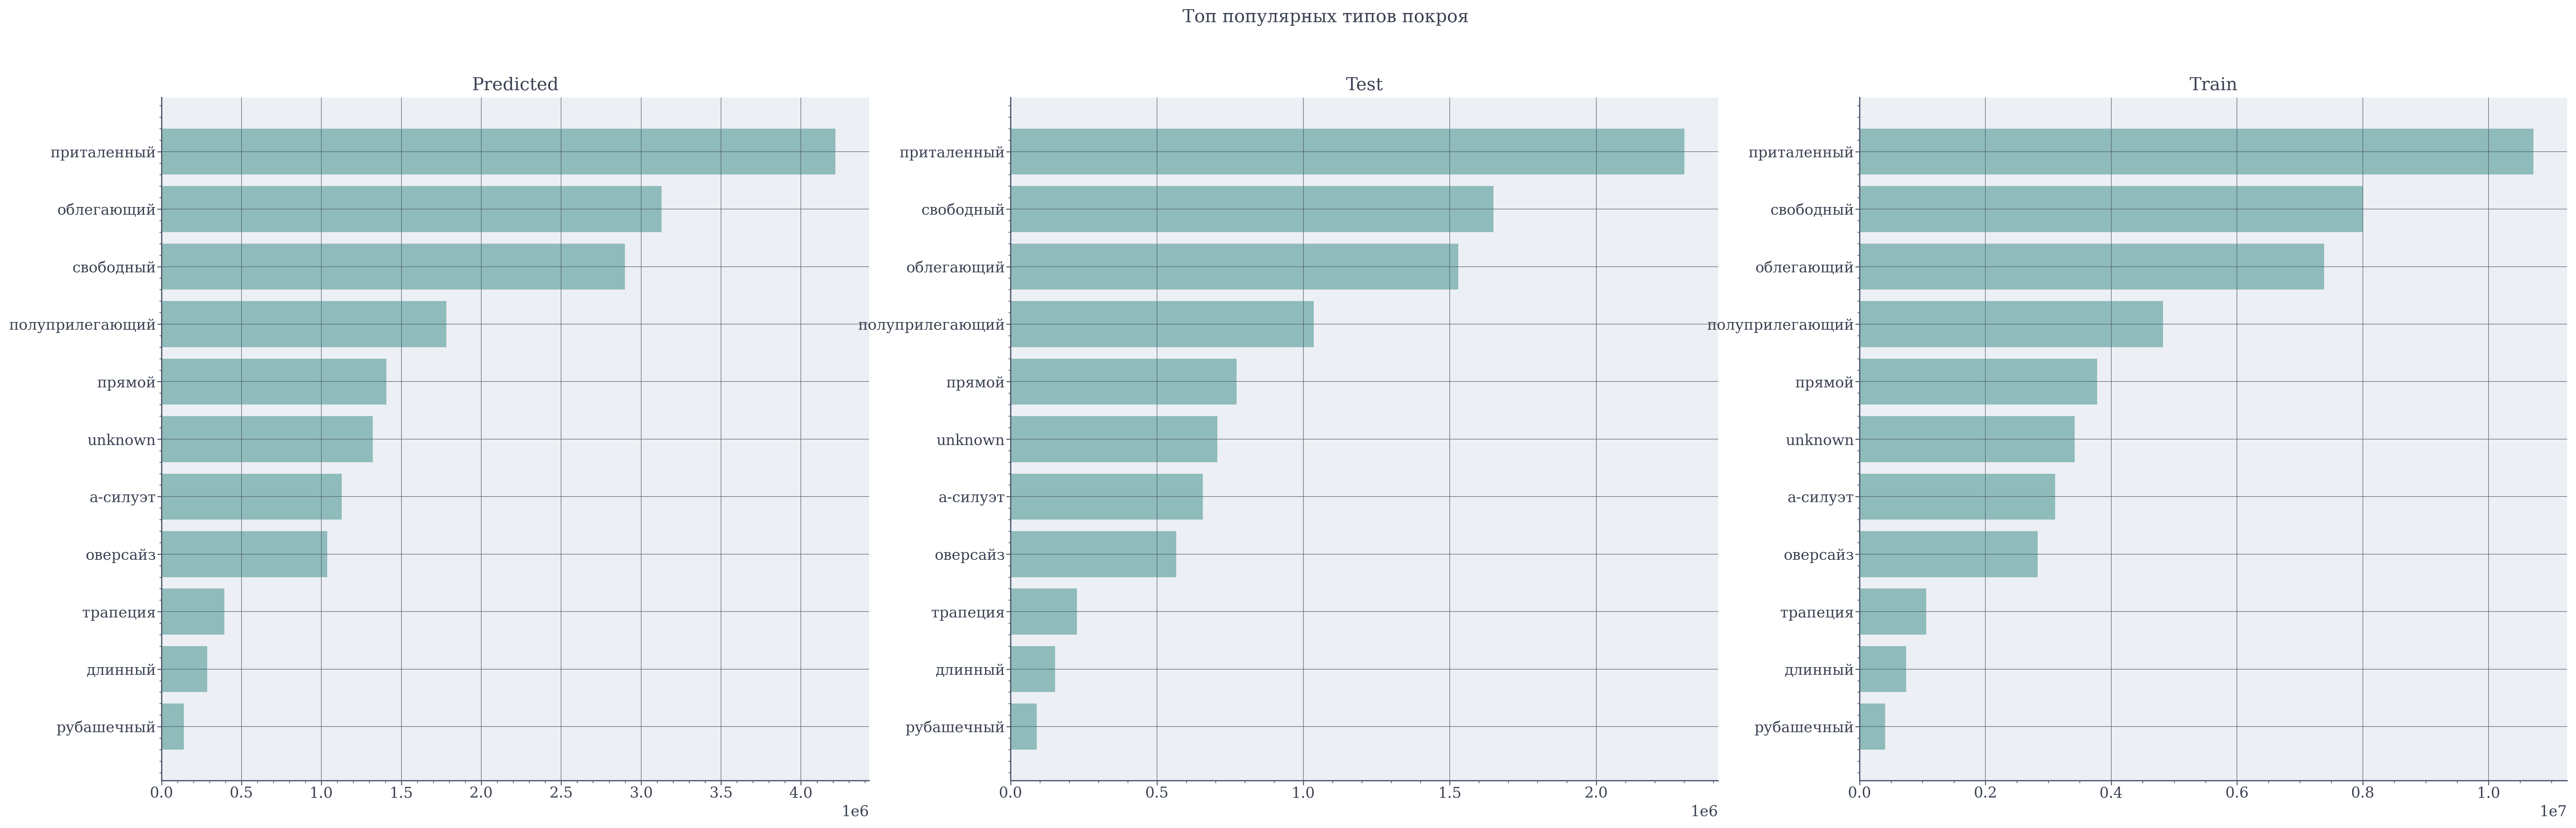

In [42]:
plot_info = {
    "title": "Топ популярных типов покроя",
    "xlabel": "",
    "ylabel": "",
    "text_1": text_for_pieplot,
    "text_2": text_for_pieplot,
}


fig, ax = plt.subplots(1, 3, figsize=(35, 10), dpi=300)

fig.suptitle(plot_info["title"])


N = 10

# Create the bar plot
ax[0].barh(
    df_cut_rating_pred["cut"].iloc[[i for i in range(N, -1, -1)]],
    df_cut_rating_pred["item_count"].iloc[[i for i in range(N, -1, -1)]],
)
ax[0].set_title("Predicted")


# Create the bar plot
ax[1].barh(
    df_cut_rating_test["cut"].iloc[[i for i in range(N, -1, -1)]],
    df_cut_rating_test["item_count"].iloc[[i for i in range(N, -1, -1)]],
)
ax[1].set_title("Test")

# Create the bar plot
ax[2].barh(
    df_cut_rating_train["cut"].iloc[[i for i in range(N, -1, -1)]],
    df_cut_rating_train["item_count"].iloc[[i for i in range(N, -1, -1)]],
)
ax[2].set_title("Train")



plt.show()

# Purpose

In [43]:
df_purpose_rating_pred = (
    df_candidates["purpose"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"count": "item_count"})
)
df_purpose_rating_pred

,purpose,item_count
0,большие размеры,9228570
1,вечернее,4977604
2,повседневная,1446896
3,беремен,771336
4,unknown,461819
5,выпускной,387402
6,домашнее,238051
7,офис,123425
8,свадьба,95144
9,кормления,81277


In [44]:
df_purpose_rating_train = (
    df_items_train.groupby(by="purpose").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_purpose_rating_train

,purpose,item_count
2,большие размеры,24798896
3,вечернее,12488055
11,повседневная,3722358
1,беремен,1923357
0,unknown,1200024
4,выпускной,1017889
5,домашнее,615765
9,офис,325594
12,свадьба,255988
6,кормления,171592


In [45]:
df_purpose_rating_test = (
    df_items_test.groupby(by="purpose").agg({"item_count": "sum"}).reset_index().sort_values(by="item_count", ascending=False)
)
df_purpose_rating_test

,purpose,item_count
2,большие размеры,5241933
3,вечернее,2623831
11,повседневная,757897
1,беремен,378478
0,unknown,244755
4,выпускной,211956
5,домашнее,138459
9,офис,64817
12,свадьба,52083
6,кормления,29813


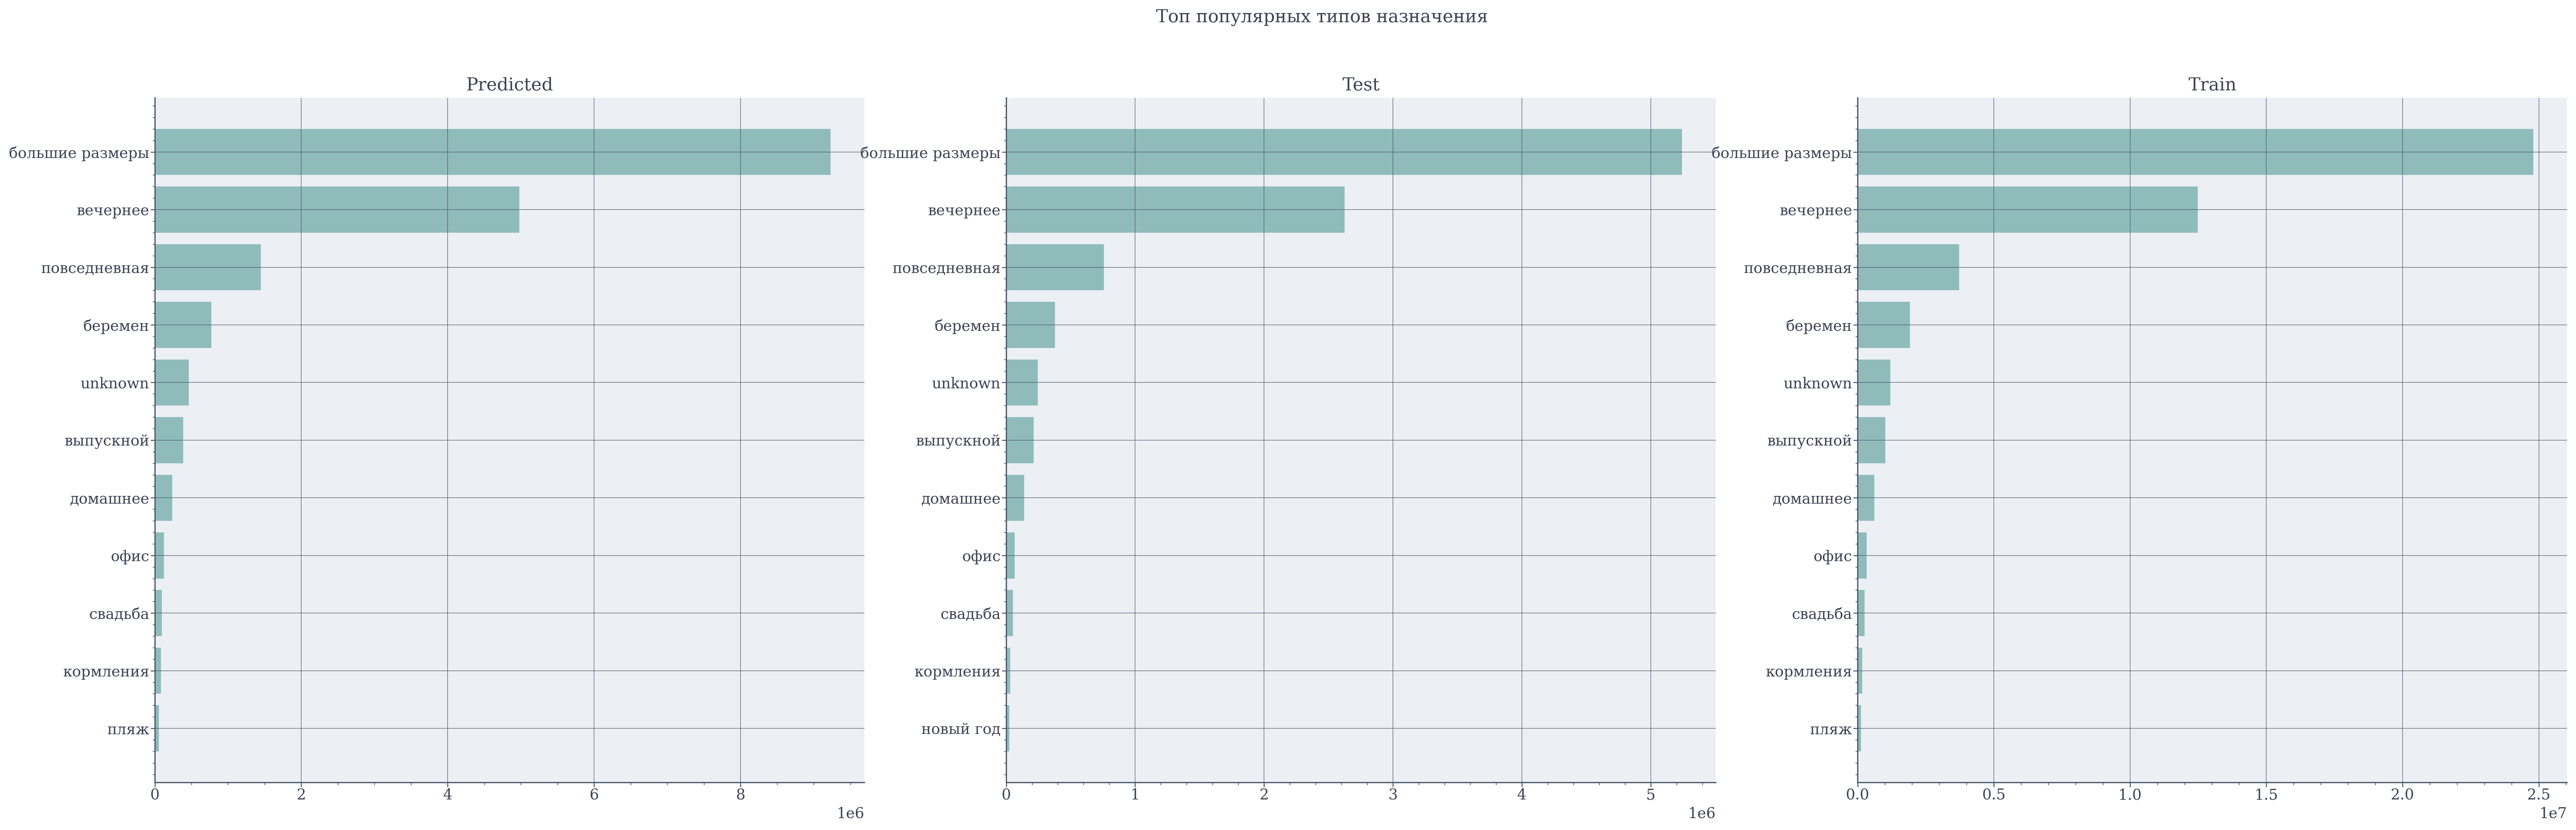

In [46]:
plot_info = {
    "title": "Топ популярных типов назначения",
    "xlabel": "",
    "ylabel": "",
    "text_1": text_for_pieplot,
    "text_2": text_for_pieplot,
}


fig, ax = plt.subplots(1, 3, figsize=(35, 10), dpi=300)

fig.suptitle(plot_info["title"])


N = 10

# Create the bar plot
ax[0].barh(
    df_purpose_rating_pred["purpose"].iloc[[i for i in range(N, -1, -1)]],
    df_purpose_rating_pred["item_count"].iloc[[i for i in range(N, -1, -1)]],
)
ax[0].set_title("Predicted")


# Create the bar plot
ax[1].barh(
    df_purpose_rating_test["purpose"].iloc[[i for i in range(N, -1, -1)]],
    df_purpose_rating_test["item_count"].iloc[[i for i in range(N, -1, -1)]],
)
ax[1].set_title("Test")

# Create the bar plot
ax[2].barh(
    df_purpose_rating_train["purpose"].iloc[[i for i in range(N, -1, -1)]],
    df_purpose_rating_train["item_count"].iloc[[i for i in range(N, -1, -1)]],
)
ax[2].set_title("Train")



plt.show()

# Пример использования модели
Допустим продавец собирается производить макси платья тогда: 
1. Рассматриваем все макси платья.
2. Смотрим на самые удачные изделия у популярных брендов.
3. Смотрим самые популярные признаки (тип рукава, покрой, вырез, цвет).
4. Решаем делать ли заказ на производстве или переходить в другой сегмент.
